# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# # Here is a helping code that will download and unzip the dataset for you.
# # Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error


from keras.layers import Input,Dense,LSTM,Dropout,Bidirectional, SimpleRNN
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima


In [3]:
# Parsing the date column with the reading

df = pd.read_csv('Traffic Data.csv',parse_dates=['date_time'])

In [4]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [6]:
# making the datetime as index of the dateframe

ts_df = df.set_index('date_time')

In [7]:
# sort the datetime index

ts_df = ts_df.sort_values(by='date_time')

<Axes: xlabel='date_time'>

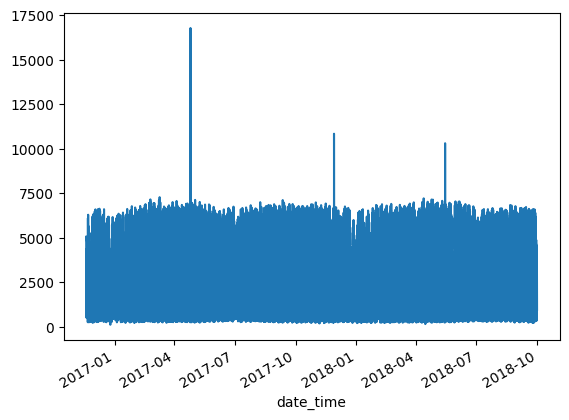

In [8]:
ts_df['traffic_volume'].plot()

In [9]:
ts_df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [10]:
# see the mean with the median to decide for the scaler in future
# getting information about other columns like snow_1h is useless due to having the same number

ts_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048395,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


In [11]:
# dropping due to having low number of row relatively to the number of rows in the dataframe

ts_df.dropna(inplace=True)

In [12]:
# checking the number of columns for encoding in the future

ts_df.select_dtypes(include='object').nunique()

,0
weather_main,10
weather_description,34


In [13]:
# dropping the useless columns that wouldn't be needed in the prediction

ts_df.drop(columns=['weather_description','snow_1h'],inplace=True)

In [14]:
# have no order this categorical feature

ts_df_encoded = pd.get_dummies(ts_df,columns=['weather_main'],dtype=int)

In [15]:
# Resampling the frequency to *days*

ts_df_encoded = ts_df_encoded.resample('D').mean()

<Axes: xlabel='date_time'>

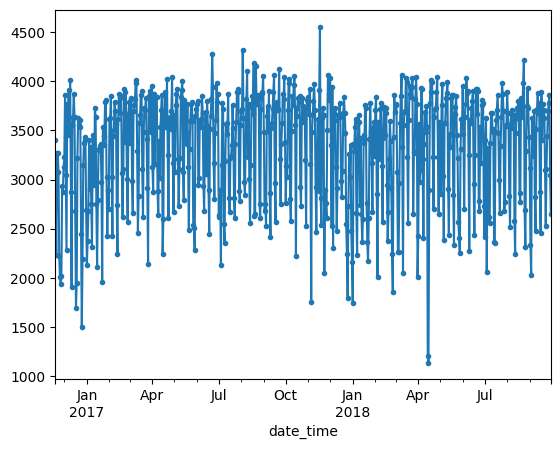

In [16]:
# See the plot and getting information about the trend and seasonality

# We can say that there could be a seasonality but the trend is almost not there

ts_df_encoded['traffic_volume'].plot(marker='.')

In [17]:
# check the number of rows after the resampling

ts_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 682 entries, 2016-11-18 to 2018-09-30
Freq: D
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   traffic_volume             682 non-null    float64
 1   temp                       682 non-null    float64
 2   rain_1h                    682 non-null    float64
 3   clouds_all                 682 non-null    float64
 4   weather_main_Clear         682 non-null    float64
 5   weather_main_Clouds        682 non-null    float64
 6   weather_main_Drizzle       682 non-null    float64
 7   weather_main_Fog           682 non-null    float64
 8   weather_main_Haze          682 non-null    float64
 9   weather_main_Mist          682 non-null    float64
 10  weather_main_Rain          682 non-null    float64
 11  weather_main_Smoke         682 non-null    float64
 12  weather_main_Snow          682 non-null    float64
 13  weather_main_Thundersto

In [18]:
ets = seasonal_decompose(ts_df_encoded['traffic_volume'],model='additive')

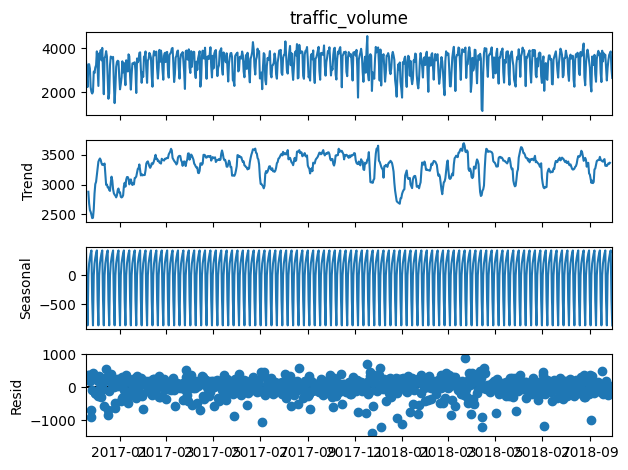

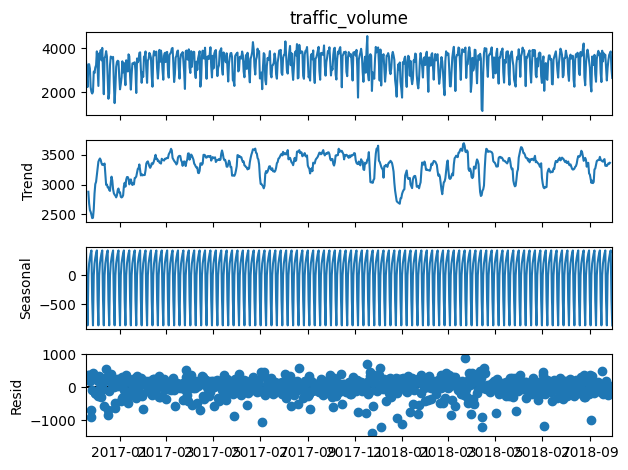

In [19]:
# can see the trend almost none but there is a slight one
# the seasonality is obvious one in the plot
# the error are there too and could be sure about it in the previous plot due to the noise in the data

ets.plot()

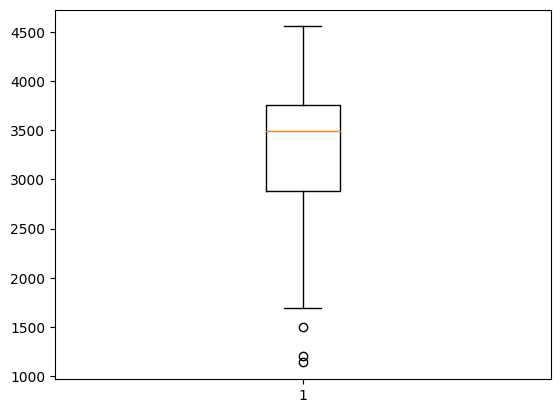

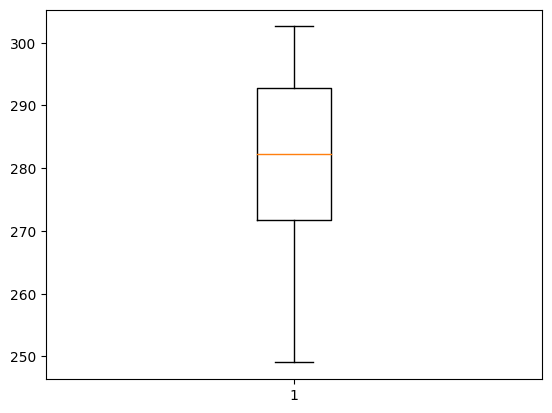

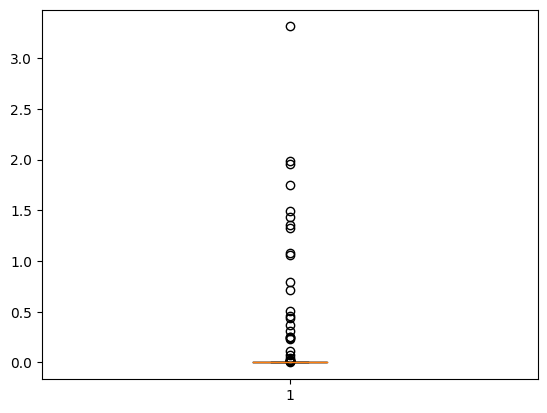

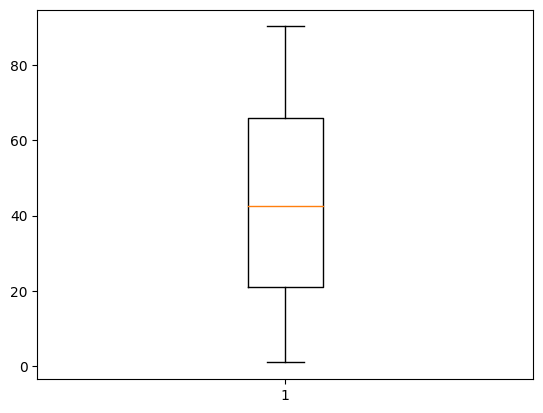

In [20]:
plt.boxplot(ts_df_encoded['traffic_volume'])
plt.show()
plt.boxplot(ts_df_encoded['temp'])
plt.show()
plt.boxplot(ts_df_encoded['rain_1h'])
plt.show()
plt.boxplot(ts_df_encoded['clouds_all'])
plt.show()

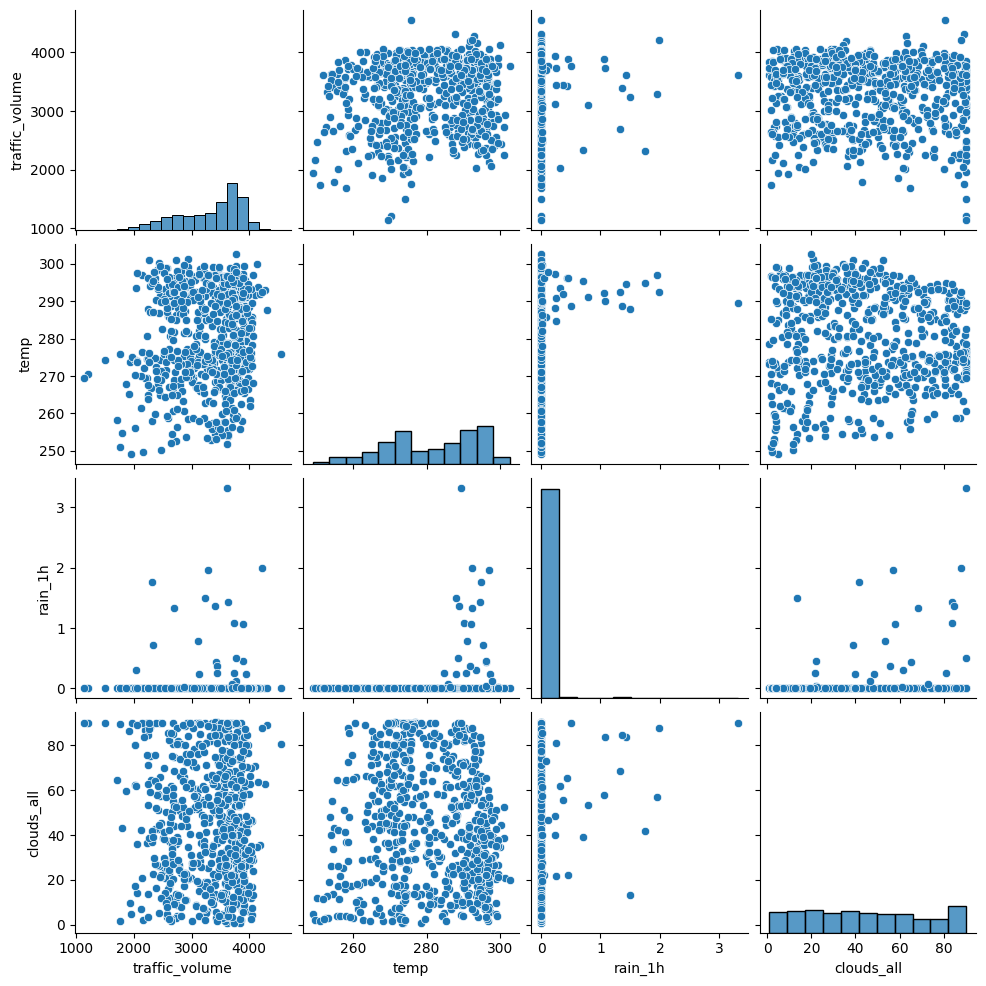

In [21]:
columns = ['traffic_volume','temp','rain_1h','clouds_all']
sns.pairplot(ts_df_encoded[columns])

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [22]:
new_df = ts_df_encoded

In [23]:
new_df['prev_traffic_volume'] = new_df['traffic_volume'].shift(1)
new_df.dropna(inplace=True)

In [24]:
new_df['diff_traffic_volume'] = new_df['traffic_volume'].diff()

new_df.dropna(inplace=True)

In [25]:
new_df['Day_of_the_Week'] = new_df.index.day_of_week

new_df['Month'] = new_df.index.month

new_df['Day_of_the_Year'] = new_df.index.day_of_year

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [26]:
X = new_df.drop(columns=['traffic_volume'])
y = new_df['traffic_volume']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=False)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [27]:
# y_mms = MinMaxScaler()
# y = y_mms.fit_transform([np.array(y)])

# y = (y - y.min()) / (y.max() - y.min())

# y_train = y_mms.transform([y_train])
# y_train_new = y_mms.fit_transform([np.array(y_train)])
# y_test_new = y_mms.fit_transform([np.array(y_test)])


mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

minimum_y = y_train.min()
maximum_y = y_train.max()

y_train = (y_train - minimum_y) / (maximum_y - minimum_y)
y_test = (y_test - minimum_y) / (maximum_y - minimum_y)

In [28]:
# mms = StandardScaler()
# X_train = mms.fit_transform(X_train)
# X_test = mms.transform(X_test)

# mean_y = y_train.mean()
# std_y = y_train.std()

# y_train = (y_train - mean_y) / (std_y)
# y_test = (y_test - mean_y) / (std_y)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [29]:
# I selected SARIMA, RNN

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [30]:
model_arima = auto_arima(
    y_train,
    start_p = 1, max_p = 5,
    start_q = 1, max_q = 5,
    d = None, D = 0,
    start_P = 1, max_P = 5,
    start_Q = 1, max_Q = 5,
    stepwise = False,
    trace=True,
    error_action='ignore',
    # information_criterion='aic',
    # maxiter = 1000,
    seasonal=True, m=1
)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-280.003, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-391.013, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-513.354, Time=0.81 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-511.465, Time=1.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-540.515, Time=1.42 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=-542.431, Time=1.57 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-281.249, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-467.102, Time=0.85 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-511.412, Time=2.52 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=-509.365, Time=3.16 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=-542.418, Time=1.40 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-346.787, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-535.318, Time=0.89 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-556.243, Time=1.50 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-519.103, Time=1.63 sec
 ARIMA(3,1

In [31]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  544
Model:               SARIMAX(4, 1, 1)   Log Likelihood                 296.533
Date:                Sun, 25 Aug 2024   AIC                           -579.067
Time:                        17:41:31   BIC                           -548.987
Sample:                    11-20-2016   HQIC                          -567.306
                         - 05-17-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.627      0.530      -0.001       0.002
ar.L1          0.3745      0.040      9.450      0.000       0.297       0.452
ar.L2         -0.4059      0.048     -8.435      0.000      -0.500      -0.312
ar.L3         -0.0097      0.047     -0.207      0.836      -0.102       0.082
ar.L4         -0.2958      0.051     -5.848      0.000      -0.395      -0.197
ma.L1         -0.9077      0.021    -42.942      0.000      -0.949      -0.866
sigma2         0.0196      0.001     17.632      0.000       0.017       0.022
===================================================================================
Ljung-Box (L1) (Q):                   2.38   Jarque-Bera (JB):                24.52
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -0.36
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
model_arima.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (4, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 1),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [33]:
y_pred_arima = model_arima.predict(n_periods=X_test.shape[0])

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

MSE for SARIMA = 0.026123227243907796


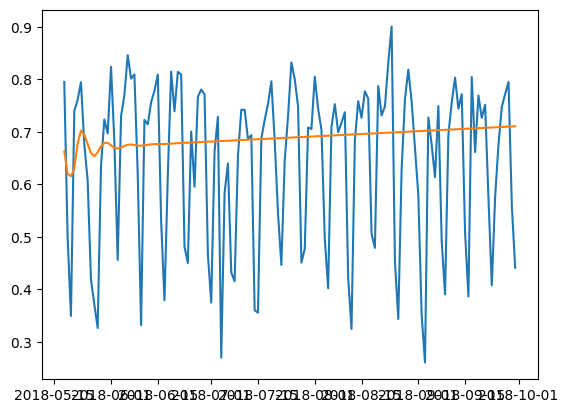

In [34]:
print(f"MSE for SARIMA = {mean_squared_error(y_pred_arima,y_test)}")


plt.plot(y_test)
plt.plot(y_pred_arima)
plt.show()


### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [35]:
model_rnn = Sequential([
    Input(shape=(X_train.shape[1],1)),
    SimpleRNN(25,return_sequences=True),
    Dropout(0.25),

    SimpleRNN(50,return_sequences=True),
    Dropout(0.25),

    SimpleRNN(75,return_sequences=True),
    Dropout(0.25),

    SimpleRNN(100,return_sequences=True),
    Dropout(0.25),

    SimpleRNN(150,return_sequences=True),
    Dropout(0.25),

    SimpleRNN(100),
    Dropout(0.25),

    Dense(1,activation='linear'),
])

In [36]:
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 18, 25)              │             675 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18, 25)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 18, 50)              │           3,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 18, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 18, 75)              │           9,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 18, 75)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 18, 100)             │          17,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 18, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 18, 150)             │          37,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 18, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 100)                 │          25,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,376 (368.66 KB)

 Trainable params: 94,376 (368.66 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model_rnn.compile(loss='mean_absolute_error',optimizer='adam')

In [38]:
early_stopping = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
history = model_rnn.fit(X_train,y_train,epochs=500,callbacks=early_stopping,validation_split=0.2)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.7558 - val_loss: 0.3194
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.5990 - val_loss: 0.3611
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.5524 - val_loss: 0.4694
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4930 - val_loss: 0.3891
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.4560 - val_loss: 0.1940
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.4551 - val_loss: 0.3325
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.4406 - val_loss: 0.7146
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.4815 - val_loss: 0.1340
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.4376 - val_loss: 0.2583
Epoch 10/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.4305 - val_loss: 0.2718
Epoch 11/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.3923 - val_loss: 0.1472
Epoch 12/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [39]:
y_pred_rnn = model_rnn.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

MSE in RNN = 0.0023331597677355015


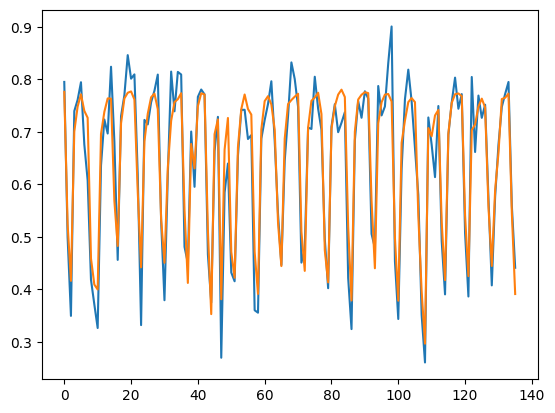

<Axes: >

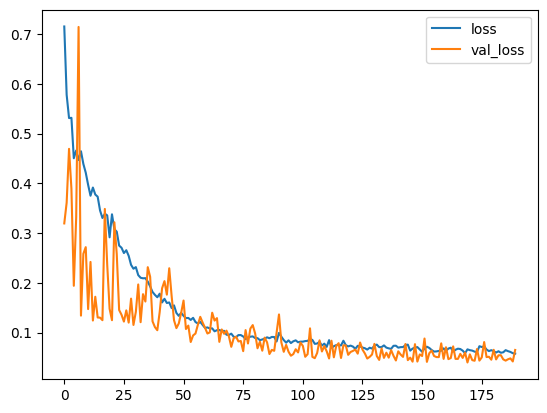

In [40]:
mse_rnn = mean_squared_error(y_test,y_pred_rnn)

print(f"MSE in RNN = {mse_rnn}")

plt.plot(np.array(y_test))
plt.plot(y_pred_rnn)
plt.show()


pd.DataFrame(history.history)[['loss','val_loss']].plot()

## Project Questions:

1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

Data Preprocessing:
- Deleted two columns due to the values are useless for my prediction. the snow_1h have just the value 0 in it. and weather_desecribtion wouldn't relate to the prediction and weather_main would be enough
- As scaler for all numerical data, I used MinMaxScaler due to having almost normalized distribution in most of the numerical features. In addition, I tested StandardScaler to the models and I got a better result with MinMaxScaler.
- there were a few missing values and I dropped the row that contain them
- I plotted the Traffic volume over the date time after doing moving average smoothing. I found that the seasonality is highly happening to the feature and the trend is there but not that much. And I confirmed it with using decomposing the trend, seasonality, residuals of the data using the method seasonal_decompose. and plot it after.
- I used few of the visualization to see few information like the distribution of the traffic volume data. and the relationships between the columns with adding box plot to look for outliers in the numerical features. I have a few of them but it wasn't that high, that's why MinMaxScaler would be affected that much.
- I scaled the data after the train_split due to not wanting the model learn before the fitting.
- I took the frequency around 1 Day because it has enough data after the moving average method and it would make sense to get the traffic volume day by day.

Feature Engineering:
- I feature engineer few of the columns like the lag, and difference, the week day and year day, etc.. I extract them from other features that could improve my prediction
- I tested with and without the feature engineering in the same models with teh same parameters. and I found a slight difference towards improvement with the feature engineering that I used.
- I used MinMaxScaler in **y** and I created manually becuase I have issues with the function.

Model Architecture:
- SARIMA:
  - The reason behind the number of (p,d,q)(P,D,Q)[m] is random. I used them multiple of times until I get the best values for my AIC. I used them with difference or without. I added a huge number in q to reach for most of the sequences and all of them result in worse and worse. until I get the best hyper-parameters and with the best time spent through fitting the model.
- RNN:
  - I used 3 hidden layers that goes to the last one and the last one result in hte output to the Dense layer. I used them multiple of times until I found the best hyper-parameters that find the best loss without overfitting, and with the best speed thorugh training.
- Other Model:
  - It could be implemented but I found these two models result in the best predictions and best values. I tested LSTM and the result was good enough but it took too much time for fitting, so I decided to replace it with SARIMA.
  - ARIMA had the same issue not thorugh time but in result, it was worse than SARIMA in multiple of levels.

Training Process:
- Epochs: becuase I implemented callbacks with early stopping, so I wasn't worry about the overfitting and that's why I used a high number
- Batch_size: I didn't change the default one
- Optimizer: Adam is the best optimizer that could result in better values. I tested SGD one time in RNN but it didn't result a good prediction, so I replace it with adam and continued using it with the rest of the testing.
- SARIMA parameters: the same as the above in the model architecture about the hyper-parameters

Loss Function and Metrics:
- I used MSE due to having a small number of Traffic Volume especially after using MinMaxScaler and that made the Traffic Volume around (-1,1) which is relatively low to use RMSE or MAE. I could use MAPE to get the percentage but MSE is fine to get a close number to 0 which is enough to get insights about the best model.

Model Tuning (If Done):
- SARIMA:
  - Tested multiple of differences and seasonal number (m) but all of them result either in inf value in AIC or a long time to calculate like around 5 mins for just getting the result of one model. so I decided to make the p,q,P,Q relatively small number to take short time and in the same time result in a good prediction in the end.
- RNN:
  - I used Dropout in different percentage of dropping and in the same time changed the units in the RNN loops, in both ways I get enough good options but what I setteled in was one the best

Overfitting and Underfitting:
- in SARIMA I didn't need to worry about the overfitting or underfitting due to the number of testing for the hyper-parameters.
- In RNN I used a high number of epochs but I added early stopping to avoid the overfitting value, and I changed the patience multiple of time to not stop too early or to stop too late.

Future Improvements:
- I could test another transformations like Box-Cox or Log Transformation in the columns
- I could try to think of more feature engineering columns
- I could test more models like SES or others
- Do a Grid-Search for finding the best hyper-parameter in SARIMA rather than testing.
